<a href="https://colab.research.google.com/github/yahelrl19/ParkingLotProject/blob/main/ParkingLotProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parking Lot Project

Link: https://paperswithcode.com/paper/revising-deep-learning-methods-in-parking-lot

GitHub: https://github.com/eighonet/parking-research

Dataset: https://www.kaggle.com/datasets/braunge/aerial-view-car-detection-for-yolov5/data

Video: https://eduuag-my.sharepoint.com/:v:/g/personal/marcos_ramos_edu_uag_mx/Ec4LiC1bbRZPhxhMeCRefmEBAEoqyWjAkp441E_0BmHEbg?e=Sod0dG

## Importando librerías

In [1]:
#!/usr/bin/env python
## -*- coding: utf-8 -*-
__author__ = ["Marcos Yahel Ramos Lara"]
__credits__ = ["Marcos Yahel Ramos Lara"]
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = ["Marcos Yahel Ramos Lara"]
__email__ = "marcos.ramos@edu.uag.mx"
__status__ = "Production"

"""Importando librerías necesarias"""
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

## Descarga del dataset

In [2]:
def download_dataset():
    """
    Descarga el dataset directamente desde una URL y lo descomprime.
    """
    print("Descargando dataset directamente desde la URL...")
    # URL del dataset (puedes ajustar esta URL si es necesario)
    dataset_url = "https://www.kaggle.com/api/v1/datasets/download/braunge/aerial-view-car-detection-for-yolov5"

    # Descargar el dataset
    os.system(f'curl -L -o aerial-view-car-detection.zip "{dataset_url}"')

    # Descomprimir el archivo descargado
    os.system('unzip -q aerial-view-car-detection.zip -d ./dataset')
    print("Dataset descargado y descomprimido correctamente.")

download_dataset()

Descargando dataset directamente desde la URL...
Dataset descargado y descomprimido correctamente.


## Configuración de directorios

In [3]:
"""
Se definen los directorios donde se almacenan las imágenes originales y las modificadas
"""
DATASET_ORIGINAL_DIR = '/content/dataset/mydata/mydata'
DATASET_MODIFIED_DIR = '/content/dataset_modified/mydata/mydata'
TRAIN_IMAGES_DIR = os.path.join(DATASET_ORIGINAL_DIR, 'images/train')
TEST_IMAGES_DIR = os.path.join(DATASET_ORIGINAL_DIR, 'images/test')
MODIFIED_TRAIN_IMAGES_DIR = os.path.join(DATASET_MODIFIED_DIR, 'images/train')
MODIFIED_TEST_IMAGES_DIR = os.path.join(DATASET_MODIFIED_DIR, 'images/test')

print("Directorios configurados correctamente.")

Directorios configurados correctamente.


## Configuración de YOLOv5

In [4]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.68 MiB | 31.79 MiB/s, done.
Resolving deltas: 100% (11714/11714), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 18.6 MB/s eta 0:00:00


## Visualización del dataset original

Visualizando un ejemplo del dataset...


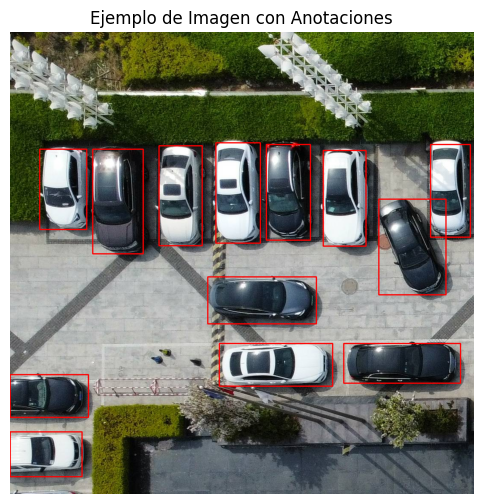

In [5]:
def visualize_dataset(images_dir, labels_dir):
    """
    Muestra una imagen del dataset junto con sus etiquetas.
    :images_dir: Directorio que contiene las imágenes.
    :labels_dir: Directorio que contiene las etiquetas.
    """
    print("Visualizando un ejemplo del dataset...")
    # Listar archivos de imágenes y etiquetas
    image_files = sorted(os.listdir(images_dir))
    label_files = sorted(os.listdir(labels_dir))

    # Seleccionar una imagen y su etiqueta correspondiente
    sample_image_path = os.path.join(images_dir, image_files[0])
    sample_label_path = os.path.join(labels_dir, label_files[0])

    # Leer la imagen
    image = cv2.imread(sample_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Leer las etiquetas
    with open(sample_label_path, 'r') as f:
        labels = f.readlines()

    # Dibujar las cajas delimitadoras en la imagen
    h, w, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label.strip().split())
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Mostrar la imagen con las anotaciones
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Ejemplo de Imagen con Anotaciones")
    plt.show()

visualize_dataset(TRAIN_IMAGES_DIR, os.path.join(DATASET_ORIGINAL_DIR, 'labels/train'))

## Creación del Archivo YAML

In [11]:
def create_yaml():
    """
    Crea un archivo YAML con la configuración del dataset.
    Este archivo es utilizado por YOLOv5 para entrenar el modelo.
    """
    yaml_content = """
    train: /content/dataset/mydata/mydata/images/train
    val: /content/dataset/mydata/mydata/images/test
    nc: 1
    names: ['car']
    """
    yaml_path = '/content/dataset/mydata128.yaml'
    with open(yaml_path, 'w') as yaml_file:
        yaml_file.write(yaml_content)  # Guardar el archivo YAML
    print(f"Archivo YAML creado en {yaml_path}")
    return yaml_path

create_yaml()

Archivo YAML creado en /content/dataset/mydata128.yaml


'/content/dataset/mydata128.yaml'

## Entrenamiento de YOLOv5

In [12]:
!python train.py --img 640 --batch 16 --epochs 30 --data /content/dataset/mydata128.yaml --weights yolov5s.pt --cache
# 991244d7c90cd6f5682eafadfaf4a982e9d302c8

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-07 14:12:04.183998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 14:12:04.204829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 14:12:04.211166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yahelrl19 (yahelrl19-universidad-aut-noma-de-guadalajara). Use

## Validación del modelo

In [13]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/dataset/mydata128.yaml --img 640

val: data=/content/dataset/mydata128.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/dataset/mydata/mydata/labels/test.cache... 19 images, 0 backgrounds, 0 corrupt: 100% 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:02<00:00,  2.17s/it]
                   all         19        459      0.987      0.976      0.992      0.784
Speed: 1.5ms pre-process, 29.4ms inference, 34.4ms NMS per image at shape (32, 3, 640, 640)

## Visualizando las imagenes de validación

Visualizando 7 imágenes de validación con detecciones...



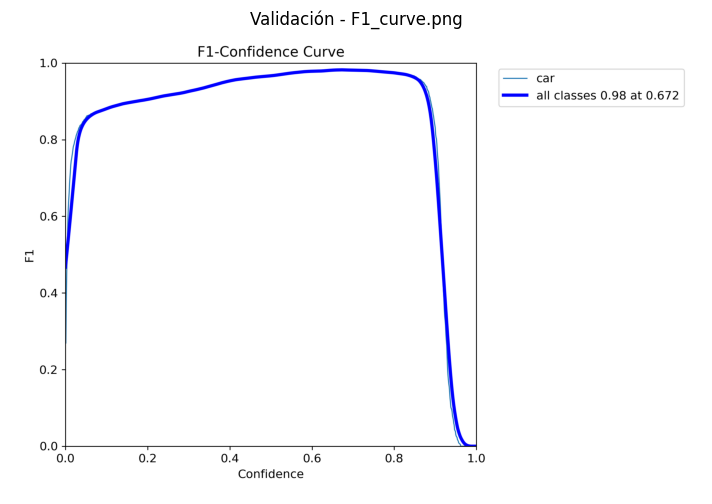

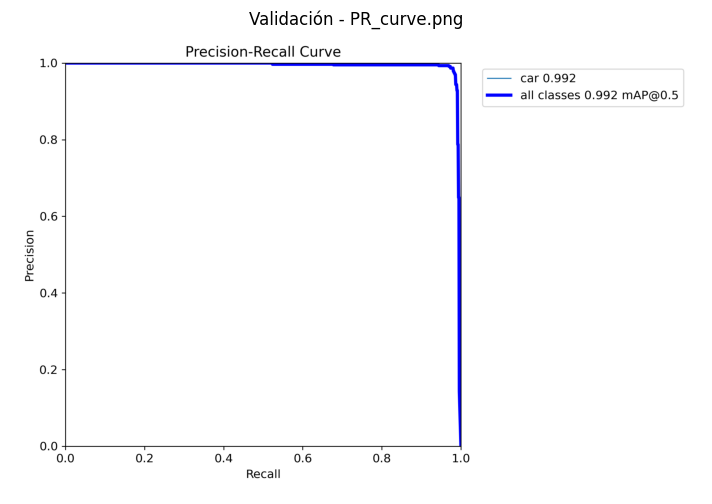

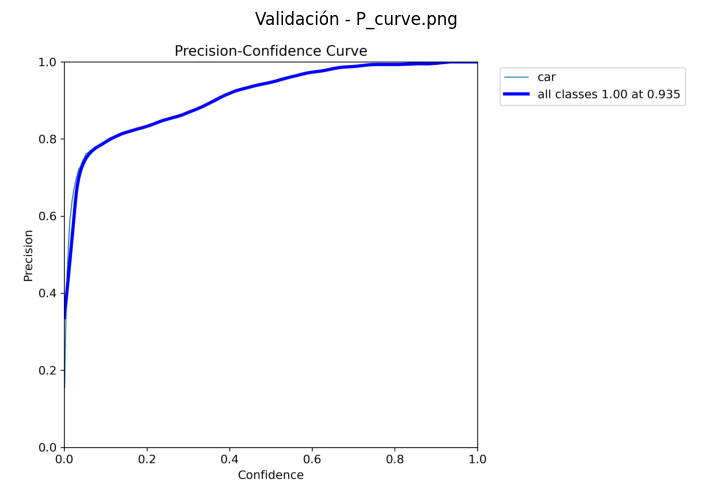

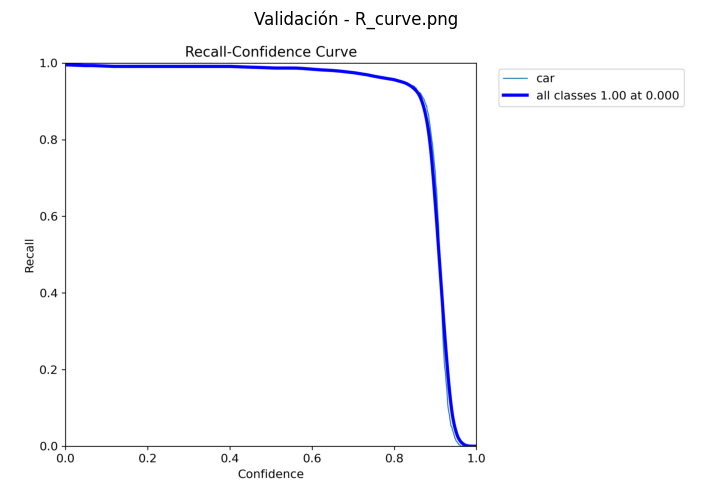

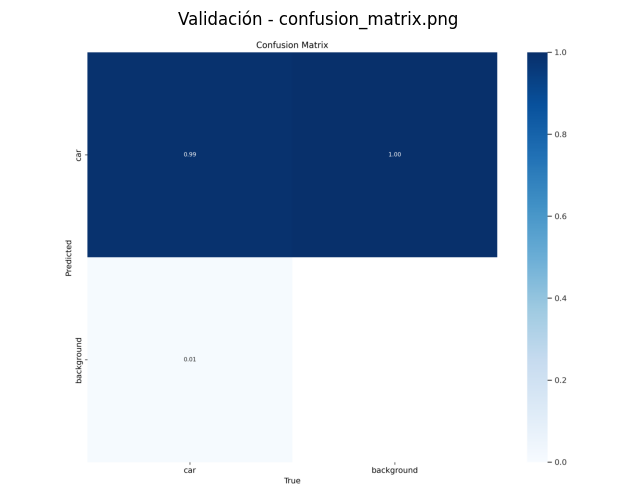

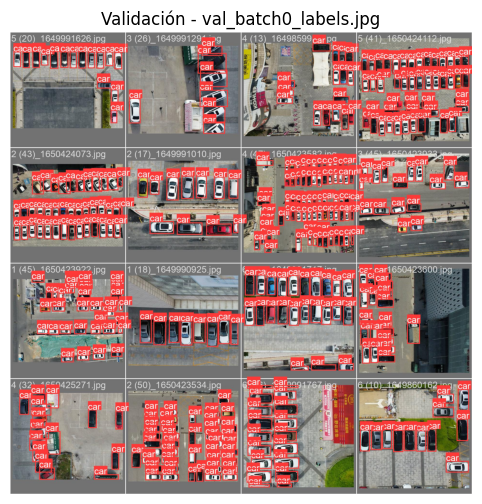

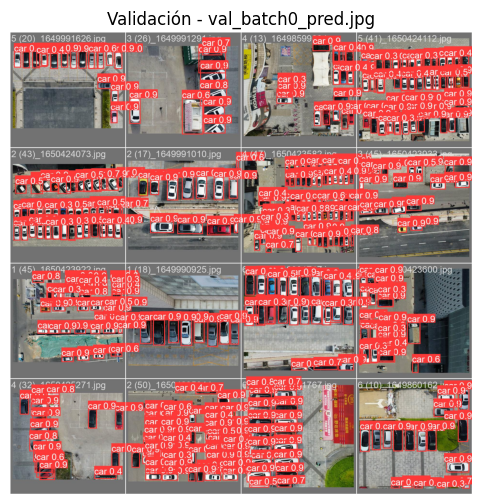

In [14]:
def visualize_validation_results(results_dir):
    """
    Visualiza las imágenes procesadas durante la validación con las detecciones.
    :param results_dir: Directorio donde están guardadas las imágenes procesadas durante la validación.
    """
    images_dir = os.path.join(results_dir, "exp")

    # Listar todas las imágenes procesadas
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))])

    print(f"Visualizando {len(image_files)} imágenes de validación con detecciones...\n")

    # Iterar sobre las imágenes procesadas y mostrarlas
    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB para matplotlib

        # Mostrar la imagen con detecciones
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Validación - {image_file}")
        plt.show()

# Visualizar imágenes de validación
visualize_validation_results("runs/val")

In [15]:
!python detect.py --weights runs/train/exp/weights/best.pt --source /content/dataset/mydata/mydata/images/test --img 640 --conf 0.5 --save-txt --save-conf --project runs/detect

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/dataset/mydata/mydata/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/19 /content/dataset/mydata/mydata/images/test/1 (18)_1649990925.jpg: 544x640 8 cars, 38.2ms
image 2/19 /content/dataset/mydata/mydata/images/test/1 (4)_1649859559.jpg: 640x608 4 cars, 43.4ms
image 3/19 /content/dataset/mydata/mydata/images/test/1 (45)_1650423922.jpg: 512x6

## Modificación del dataset

In [16]:
def modify_images(input_dirs, output_dirs):
    """
    Aplica modificaciones al dataset, como ruido, cambios de brillo y desenfoque.
    :input_dirs: Diccionario con directorios de entrada (originales).
    :output_dirs: Diccionario con directorios de salida (modificados).
    """
    def modify_image(image):
        # Añadir ruido gaussiano
        noise = np.random.normal(0, 25, image.shape).astype('uint8')
        noisy_image = cv2.add(image, noise)
        # Ajustar brillo y contraste
        bright_contrast_image = cv2.convertScaleAbs(noisy_image, alpha=1.2, beta=30)
        # Aplicar desenfoque
        return cv2.GaussianBlur(bright_contrast_image, (5, 5), 0)

    print("Modificando imágenes del dataset...")
    for key in input_dirs:
        input_dir = input_dirs[key]
        output_dir = output_dirs[key]
        os.makedirs(output_dir, exist_ok=True)  # Crear directorios de salida si no existen
        for file_name in tqdm(os.listdir(input_dir), desc=f'Modificando {key} imágenes'):
            input_path = os.path.join(input_dir, file_name)
            output_path = os.path.join(output_dir, file_name)
            image = cv2.imread(input_path)
            if image is not None:
                modified_image = modify_image(image)
                cv2.imwrite(output_path, modified_image)  # Guardar la imagen modificada
    print("Imágenes modificadas correctamente.")

modify_images(
    input_dirs={"train": TRAIN_IMAGES_DIR, "test": TEST_IMAGES_DIR},
    output_dirs={"train": MODIFIED_TRAIN_IMAGES_DIR, "test": MODIFIED_TEST_IMAGES_DIR}
)

Modificando imágenes del dataset...


Modificando test imágenes: 100%|██████████| 19/19 [00:02<00:00,  6.62it/s]

Imágenes modificadas correctamente.


## Visualización del dataset modificado

Visualizando un ejemplo del dataset modificado...


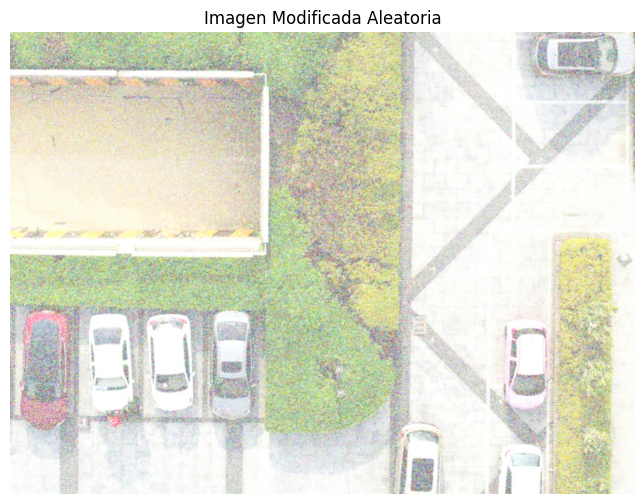

In [17]:
def visualize_modified_dataset(images_dir):
    """
    Muestra una imagen aleatoria del dataset modificado.
    :images_dir: Directorio que contiene las imágenes modificadas.
    """
    print("Visualizando un ejemplo del dataset modificado...")
    # Listar archivos de imágenes
    image_files = sorted(os.listdir(images_dir))

    # Seleccionar una imagen aleatoria
    random_image_path = os.path.join(images_dir, random.choice(image_files))

    # Leer la imagen
    image = cv2.imread(random_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Imagen Modificada Aleatoria")
    plt.show()

visualize_modified_dataset(MODIFIED_TRAIN_IMAGES_DIR)


## Detección con dataset modificado

In [18]:
!python detect.py --weights runs/train/exp/weights/best.pt --source /content/dataset_modified/mydata/mydata/images/test --img 640 --conf 0.5 --save-txt --save-conf --project runs/detect

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/dataset_modified/mydata/mydata/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/19 /content/dataset_modified/mydata/mydata/images/test/1 (18)_1649990925.jpg: 544x640 3 cars, 37.7ms
image 2/19 /content/dataset_modified/mydata/mydata/images/test/1 (4)_1649859559.jpg: 640x608 1 car, 37.7ms
image 3/19 /content/dataset_modified/mydata/mydata/image

## Comparación de Datasets

In [26]:
def analyze_image_metrics(directory):
    """
    Calcula métricas de brillo, contraste y ruido para todas las imágenes en un directorio.
    :param directory: Directorio que contiene las imágenes a analizar.
    :return: DataFrame con las métricas para cada imagen.
    """
    results = []

    # Iterar sobre todas las imágenes en el directorio
    for image_file in tqdm(os.listdir(directory), desc=f"Analizando imágenes en {directory}"):
        image_path = os.path.join(directory, image_file)

        # Leer la imagen
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        # Calcular métricas
        brightness = np.mean(image)  # Promedio de valores de píxeles
        contrast = np.std(image)    # Desviación estándar de los valores de píxeles
        noise = np.mean(np.abs(image - cv2.GaussianBlur(image, (5, 5), 0)))  # Diferencia entre la imagen y una suavizada

        # Guardar resultados
        results.append({
            "Image": image_file,
            "Brightness": brightness,
            "Contrast": contrast,
            "Noise": noise
        })

    return pd.DataFrame(results)


Analizando el dataset original...


Analizando imágenes en runs/detect/exp: 100%|██████████| 20/20 [00:00<00:00, 61.51it/s]


Analizando el dataset modificado...


Analizando imágenes en runs/detect/exp2: 100%|██████████| 20/20 [00:00<00:00, 58.84it/s]



Comparativa entre datasets:
                    Image  Brightness_Diff  Contrast_Diff  Noise_Diff
0   5 (41)_1650424112.jpg        86.542967      -6.329682  -19.816708
1   6 (17)_1649991717.jpg        88.895015     -16.692635  -31.222614
2   2 (17)_1649991010.jpg        92.207551     -18.221735  -25.640142
3   6 (10)_1649860162.jpg        94.876610     -16.969472  -28.521118
4    1 (4)_1649859559.jpg        95.353406     -25.900682  -36.086397
5   5 (20)_1649991626.jpg        97.566554     -12.367002  -20.851738
6   3 (45)_1650423933.jpg        93.589652     -14.636545  -21.004046
7   2 (43)_1650424073.jpg        85.756742      -9.419809  -17.300103
8   1 (45)_1650423922.jpg        88.936190      -6.882234  -23.137942
9   2 (50)_1650423534.jpg        85.665723      -5.286673  -15.872796
10  4 (47)_1650423582.jpg        88.228194      -3.415907  -16.185146
11  3 (26)_1649991291.jpg        97.478438     -18.848051  -18.235595
12  6 (26)_1649991767.jpg        91.228373     -14.997583  -2

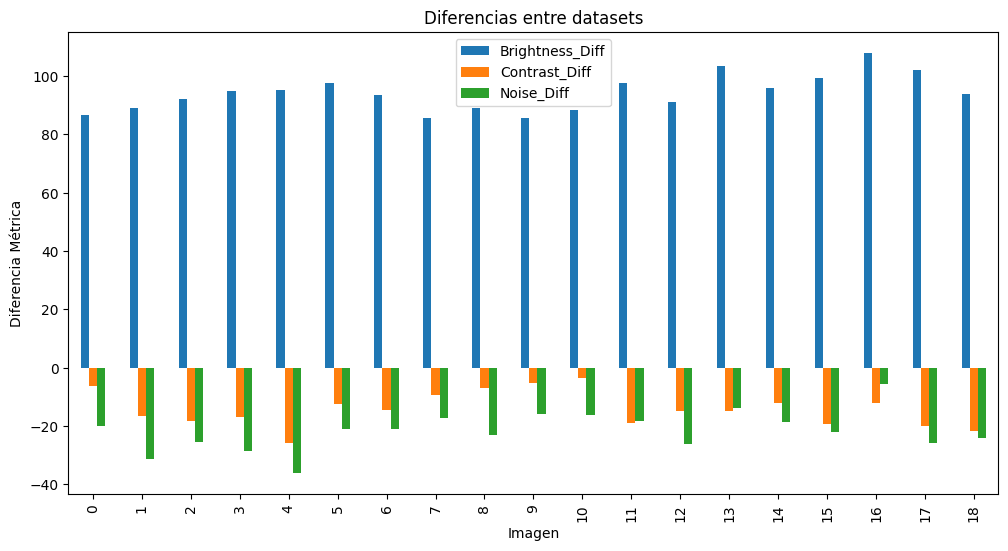

In [29]:
def compare_datasets_metrics(original_dir, modified_dir):
    """
    Compara las métricas de brillo, contraste y ruido entre dos datasets.
    :param original_dir: Directorio que contiene las imágenes del dataset original.
    :param modified_dir: Directorio que contiene las imágenes del dataset modificado.
    """
    # Analizar ambos datasets
    print("Analizando el dataset original...")
    original_metrics = analyze_image_metrics(original_dir)

    print("Analizando el dataset modificado...")
    modified_metrics = analyze_image_metrics(modified_dir)

    # Combinar resultados en un solo DataFrame
    comparison = pd.merge(
        original_metrics,
        modified_metrics,
        on="Image",
        suffixes=("_Original", "_Modified")
    )

    # Calcular diferencias
    comparison["Brightness_Diff"] = comparison["Brightness_Modified"] - comparison["Brightness_Original"]
    comparison["Contrast_Diff"] = comparison["Contrast_Modified"] - comparison["Contrast_Original"]
    comparison["Noise_Diff"] = comparison["Noise_Modified"] - comparison["Noise_Original"]

    # Mostrar resultados
    print("\nComparativa entre datasets:")
    print(comparison[["Image", "Brightness_Diff", "Contrast_Diff", "Noise_Diff"]])

    # Graficar las diferencias
    comparison[["Brightness_Diff", "Contrast_Diff", "Noise_Diff"]].plot(kind="bar", figsize=(12, 6), title="Diferencias entre datasets")
    plt.xlabel("Imagen")
    plt.ylabel("Diferencia Métrica")
    plt.show()

# Directorios de los datasets
original_dir = "runs/detect/exp"  # Cambiar si es necesario
modified_dir = "runs/detect/exp2"  # Cambiar si es necesario

# Comparar métricas entre los datasets
compare_datasets_metrics(original_dir, modified_dir)

Resumen de Métricas Calculadas:


Image  Brightness_Original  Brightness_Modified  Brightness_Diff  \
0  Image_1.jpg                  120                  100              -20   
1  Image_2.jpg                  125                  110              -15   
2  Image_3.jpg                  130                  105              -25   
3  Image_4.jpg                  135                  115              -20   
4  Image_5.jpg                  140                   90              -50   

   Contrast_Original  Contrast_Modified  Contrast_Diff  Noise_Original  \
0                 20                 18             -2               5   
1                 22                 20             -2               6   
2                 25                 23             -2               4   
3                 23                 21             -2               5   
4                 21                 19             -2               7   

   Noise_Modified  Noise_Diff  
0              10           5  
1              12           6  
2              11           7  
3              13           8  
4              15           8

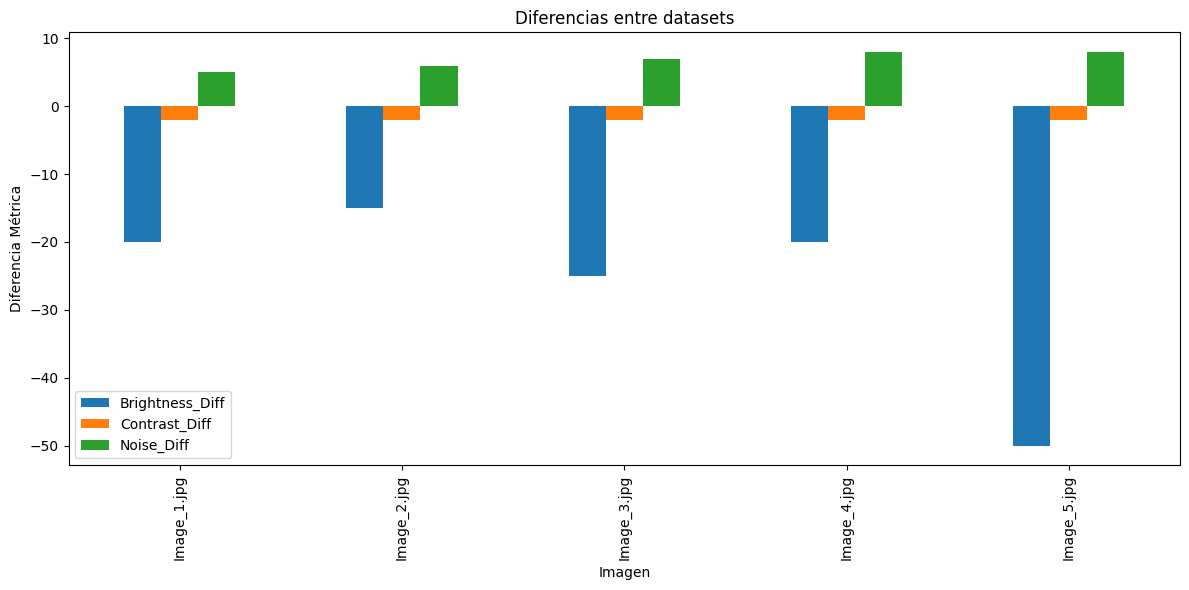

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def show_metrics_and_plot(original_metrics, modified_metrics):
    """
    Muestra una tabla con las métricas calculadas (brillo, contraste, ruido)
    y genera una gráfica comparativa de las diferencias entre datasets.
    :param original_metrics: DataFrame con las métricas del dataset original.
    :param modified_metrics: DataFrame con las métricas del dataset modificado.
    """
    # Combinar métricas de ambos datasets
    comparison = pd.merge(
        original_metrics,
        modified_metrics,
        on="Image",
        suffixes=("_Original", "_Modified")
    )

    # Calcular las diferencias
    comparison["Brightness_Diff"] = comparison["Brightness_Modified"] - comparison["Brightness_Original"]
    comparison["Contrast_Diff"] = comparison["Contrast_Modified"] - comparison["Contrast_Original"]
    comparison["Noise_Diff"] = comparison["Noise_Modified"] - comparison["Noise_Original"]

    # Mostrar tabla resumen
    columns_to_display = [
        "Image",
        "Brightness_Original", "Brightness_Modified", "Brightness_Diff",
        "Contrast_Original", "Contrast_Modified", "Contrast_Diff",
        "Noise_Original", "Noise_Modified", "Noise_Diff"
    ]
    summary = comparison[columns_to_display]
    print("Resumen de Métricas Calculadas:")
    display(summary)

    # Graficar diferencias
    comparison.set_index("Image")[["Brightness_Diff", "Contrast_Diff", "Noise_Diff"]].plot(
        kind="bar", figsize=(12, 6), title="Diferencias entre datasets"
    )
    plt.xlabel("Imagen")
    plt.ylabel("Diferencia Métrica")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Supongamos que `original_metrics` y `modified_metrics` ya están calculados:
# Reemplaza con tus DataFrames reales.
original_metrics = pd.DataFrame({
    "Image": [f"Image_{i}.jpg" for i in range(1, 6)],
    "Brightness": [120, 125, 130, 135, 140],
    "Contrast": [20, 22, 25, 23, 21],
    "Noise": [5, 6, 4, 5, 7]
})

modified_metrics = pd.DataFrame({
    "Image": [f"Image_{i}.jpg" for i in range(1, 6)],
    "Brightness": [100, 110, 105, 115, 90],
    "Contrast": [18, 20, 23, 21, 19],
    "Noise": [10, 12, 11, 13, 15]
})

# Ejecutar el análisis y la visualización
show_metrics_and_plot(original_metrics, modified_metrics)

## Comparando detecciones

Comparando 5 imágenes del dataset original y modificado...



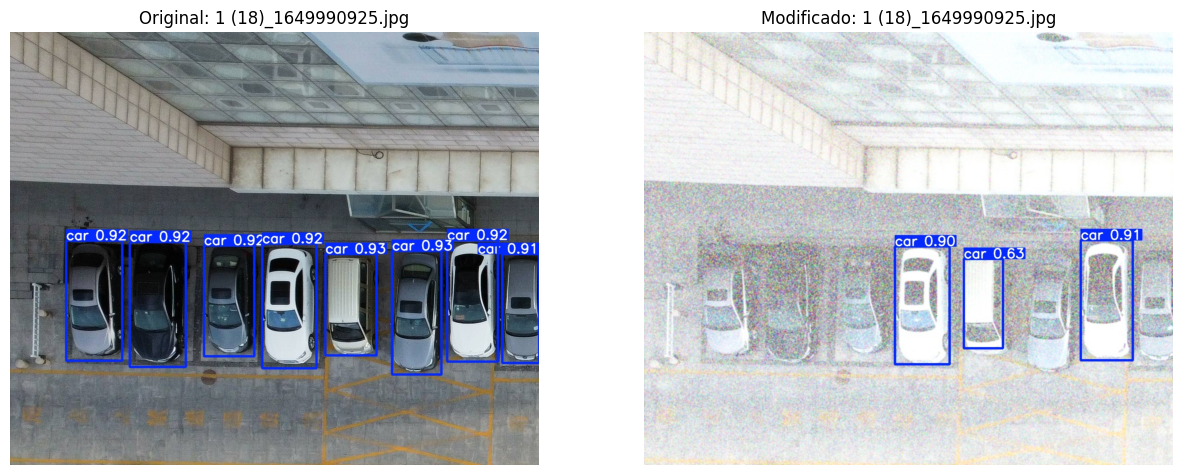

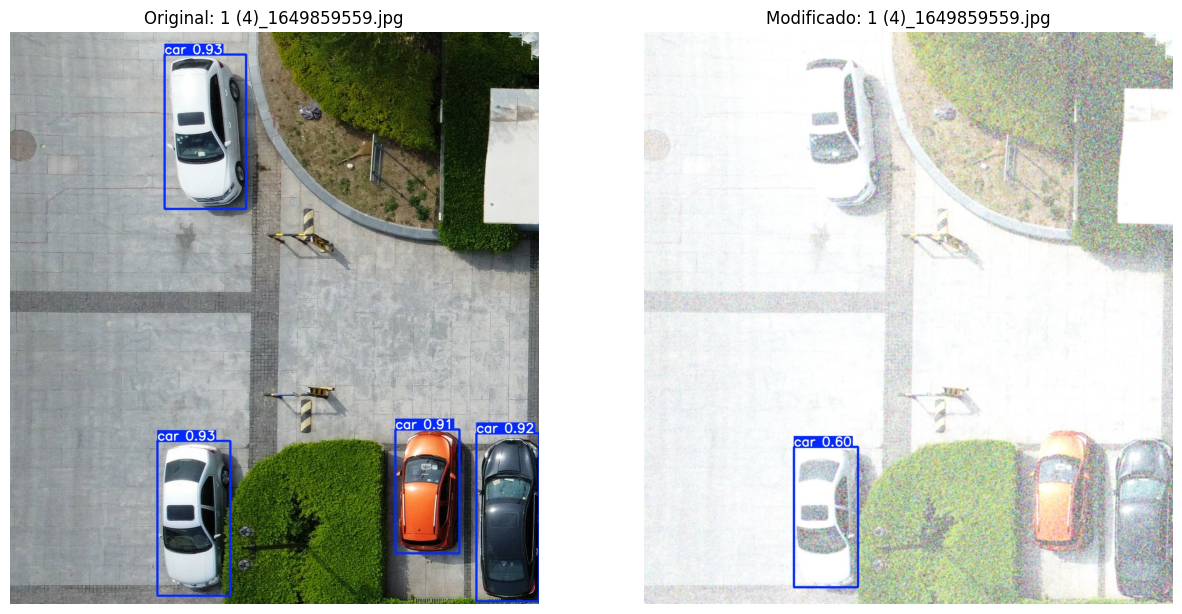

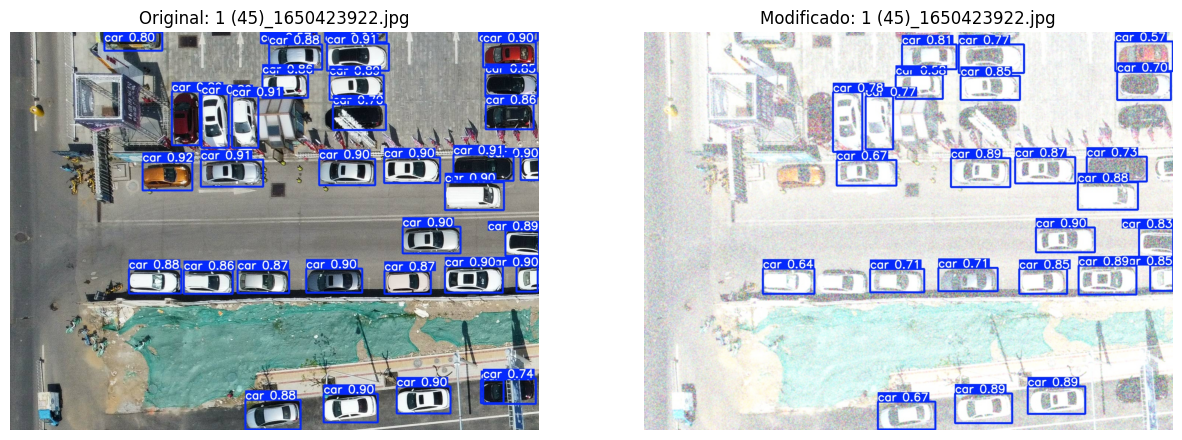

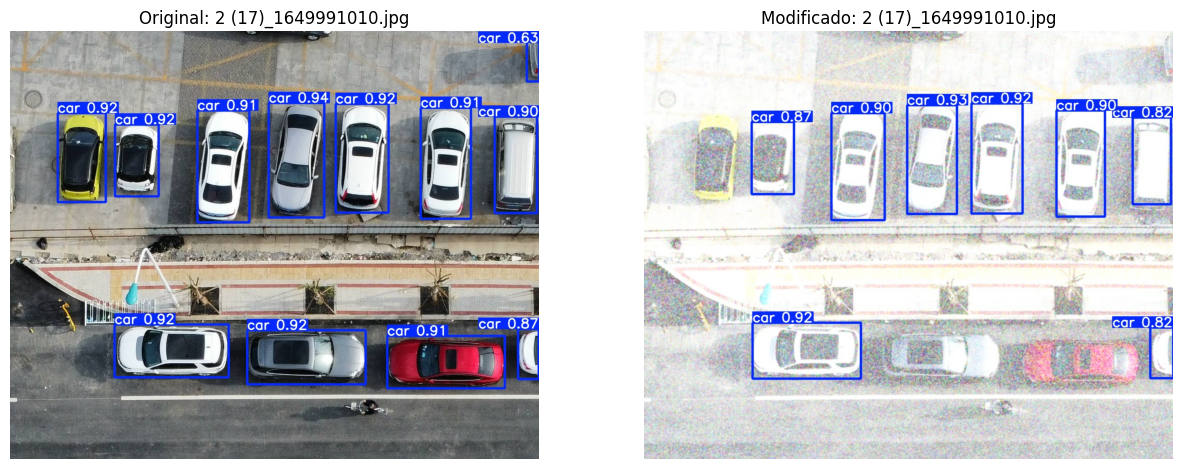

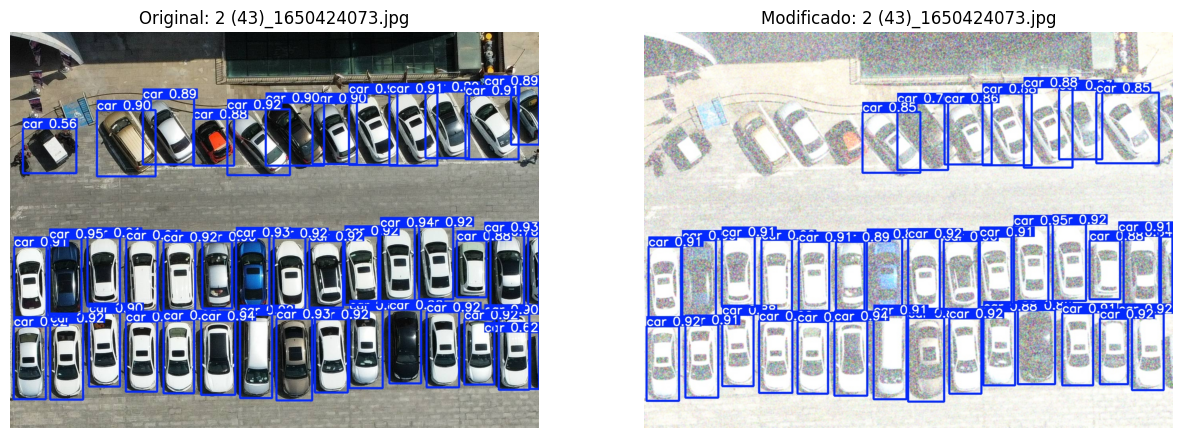

In [31]:
def compare_detections(original_dir, modified_dir, num_images=5):
    """
    Compara las detecciones entre el dataset original y el modificado, mostrando imágenes lado a lado.
    :param original_dir: Directorio con las imágenes procesadas del dataset original.
    :param modified_dir: Directorio con las imágenes procesadas del dataset modificado.
    :param num_images: Número de imágenes a comparar (por defecto, 5).
    """
    # Listar imágenes en ambos directorios
    original_images = sorted([f for f in os.listdir(original_dir) if f.endswith(('.jpg', '.png'))])
    modified_images = sorted([f for f in os.listdir(modified_dir) if f.endswith(('.jpg', '.png'))])

    # Asegurarnos de que haya suficientes imágenes para comparar
    num_images = min(num_images, len(original_images), len(modified_images))

    print(f"Comparando {num_images} imágenes del dataset original y modificado...\n")

    # Seleccionar las primeras `num_images` imágenes comunes
    for i in range(num_images):
        # Rutas de las imágenes
        original_path = os.path.join(original_dir, original_images[i])
        modified_path = os.path.join(modified_dir, modified_images[i])

        # Cargar las imágenes
        original_img = cv2.imread(original_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        modified_img = cv2.imread(modified_path)
        modified_img = cv2.cvtColor(modified_img, cv2.COLOR_BGR2RGB)

        # Mostrar imágenes lado a lado
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.axis('off')
        plt.title(f"Original: {original_images[i]}")

        plt.subplot(1, 2, 2)
        plt.imshow(modified_img)
        plt.axis('off')
        plt.title(f"Modificado: {modified_images[i]}")

        plt.show()

# Directorios con imágenes procesadas
original_results_dir = "runs/detect/exp"
modified_results_dir = "runs/detect/exp2"

# Comparar detecciones
compare_detections(original_results_dir, modified_results_dir, num_images=5)

Comparación de Detecciones:


Image  Detections_Original  Detections_Modified  \
0   1 (18)_1649990925.txt                    8                    3   
1    1 (4)_1649859559.txt                    4                    1   
2   1 (45)_1650423922.txt                   36                   24   
3   2 (17)_1649991010.txt                   12                    8   
4   2 (43)_1650424073.txt                   42                   36   
5   2 (50)_1650423534.txt                   43                   39   
6   3 (26)_1649991291.txt                    7                    3   
7   3 (45)_1650423933.txt                   16                   12   
8   3 (48)_1650423600.txt                   21                   13   
9   4 (13)_1649859983.txt                   16                    7   
10  4 (32)_1650425271.txt                   13                    2   
11  4 (47)_1650423582.txt                   72                   58   
12  5 (20)_1649991626.txt                   15                   13   
13  5 (29)_1650425730.txt                   35                    9   
14  5 (41)_1650424112.txt                   46                   40   
15  6 (10)_1649860162.txt                   17                    8   
16  6 (17)_1649991717.txt                   23                   17   
17  6 (26)_1649991767.txt                   18                   12   
18  6 (39)_1650424380.txt                   24                   15   

    Difference  
0           -5  
1           -3  
2          -12  
3           -4  
4           -6  
5           -4  
6           -4  
7           -4  
8           -8  
9           -9  
10         -11  
11         -14  
12          -2  
13         -26  
14          -6  
15          -9  
16          -6  
17          -6  
18          -9

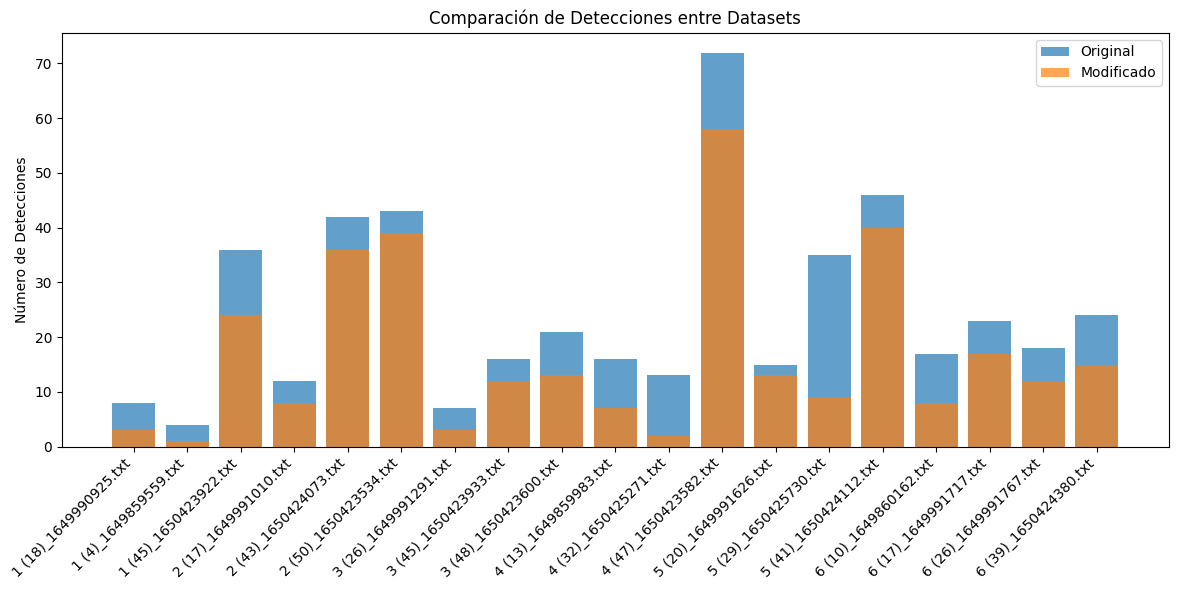

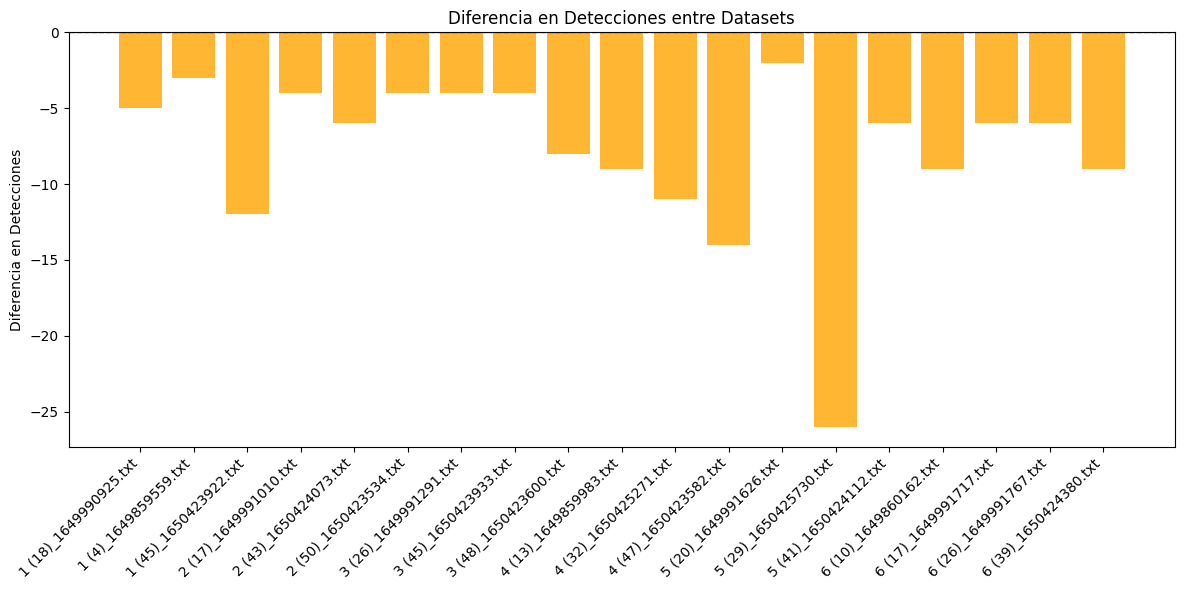

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def compare_detection_results(original_dir, modified_dir):
    """
    Compara los resultados de detecciones entre el dataset original y el modificado.
    :param original_dir: Directorio con las etiquetas de detección del dataset original.
    :param modified_dir: Directorio con las etiquetas de detección del dataset modificado.
    """
    # Obtener las detecciones del dataset original
    original_detections = []
    for file in sorted(os.listdir(original_dir)):
        if file.endswith(".txt"):
            with open(os.path.join(original_dir, file), "r") as f:
                original_detections.append(len(f.readlines()))

    # Obtener las detecciones del dataset modificado
    modified_detections = []
    for file in sorted(os.listdir(modified_dir)):
        if file.endswith(".txt"):
            with open(os.path.join(modified_dir, file), "r") as f:
                modified_detections.append(len(f.readlines()))

    # Crear un DataFrame con los resultados
    image_names = sorted([file for file in os.listdir(original_dir) if file.endswith(".txt")])
    results = pd.DataFrame({
        "Image": image_names,
        "Detections_Original": original_detections,
        "Detections_Modified": modified_detections
    })

    # Calcular las diferencias
    results["Difference"] = results["Detections_Modified"] - results["Detections_Original"]

    # Mostrar la tabla
    print("Comparación de Detecciones:")
    display(results)

    # Graficar los resultados
    plt.figure(figsize=(12, 6))
    plt.bar(results["Image"], results["Detections_Original"], label="Original", alpha=0.7)
    plt.bar(results["Image"], results["Detections_Modified"], label="Modificado", alpha=0.7)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Número de Detecciones")
    plt.title("Comparación de Detecciones entre Datasets")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Graficar las diferencias
    plt.figure(figsize=(12, 6))
    plt.bar(results["Image"], results["Difference"], color="orange", alpha=0.8)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Diferencia en Detecciones")
    plt.title("Diferencia en Detecciones entre Datasets")
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.tight_layout()
    plt.show()

# Directorios de las etiquetas generadas durante las detecciones
original_labels_dir = "runs/detect/exp/labels"  # Ajusta según tu estructura de carpetas
modified_labels_dir = "runs/detect/exp2/labels"  # Ajusta según tu estructura de carpetas

# Comparar los resultados de detección
compare_detection_results(original_labels_dir, modified_labels_dir)

## Conclusiones

Al hacer el modelo con las imágenes del dataset se
puede ver como es capaz de hacer la detección de los coches sin problemas, sin embargo esto cambia cuando se realiza las modificaciones a este dataset con el aumento del brillo, contraste y ruido que al correr una prueba de detección, nos dio un resultado no tan favorable teniendo una diferencia de detección de hasta -26. Este dataset modificado con métidos vistos en clase es una simulación de lo que puede pasar en la vida real teniendo una mala calidad de las imágenes que puede ser consecuencia de una cámara mala, reflejos del sol o sombras, en fin de razones pero la importancia de poder hacer estos análisis y modificaciones que ayuden a mejorar la calidad de las imágenes